## Using a PACDataFrame for PAC in Spark

First, we set up our Spark session and import the data.

In [1]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import lower, col, count, concat_ws
from pyspark.sql.types import Row
from pyspark import RDD
from typing import List, Tuple, Callable, Dict, Optional, Any, NamedTuple
import numpy as np
import scipy.stats as stats
from tqdm import tqdm

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, minimal_permutation_distance

spark = (SparkSession.builder.appName("pacdb")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", ".spark")
         .enableHiveSupport()
         .getOrCreate())

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/14 02:58:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
lung_df = spark.read.parquet("./data/lung.parquet")
#lung_df.write.saveAsTable("lung", mode="overwrite") # for SQL queries

smokers = lung_df.filter(lung_df["Smoking"] >= 3) # Smoking is on 1-7 scale
smokers.count()

597

#### Create PACDataFrame

In [3]:
# 0. Do all joins, etc. to get the data you want into a single Spark DataFrame. Turn it into a PACDataFrame.
spark_df: DataFrame = lung_df
pac_lung_df: PACDataFrame = PACDataFrame.fromDataFrame(lung_df)
               
# Define your query as a function that takes a DataFrame
def A(x: DataFrame) -> int:
    """Query to make private, $A(x)$ in the PAC-ML paper."""
    y = (x.filter(lung_df["Smoking"] >= 3)
             .count())
    return y

# Attach the predicate function to the PACDataFrame
pac_lung_df = pac_lung_df.withQuery(A)

#### 1. Sampling
Set the sampler options on the PACDataFrame, then call the sample method to sample the data. The samples constitute $X$.

In the future, the sample method will be called internally by PACDataFrame such that the user does not need to handle the inputs ($X$) or outputs ($Y$) but rather only needs to set parameters and issue a query.

In [4]:
# 1. Sampling
# Set sampler options on the PACDataFrame
pac_lung_df = (pac_lung_df.withSamplerOptions(
                    SamplerOptions(
                        withReplacement=False, 
                        fraction=0.5
                    ))
                    .setNumberOfTrials(200)
                    .setMutualInformationBound(1./8))

pac_lung_df

In [5]:
pac_lung_df._subsample()
pac_lung_df.X[0]

Subsample:   0%|          | 0/400 [00:00<?, ?it/s]

Subsample: 100%|██████████| 400/400 [00:02<00:00, 167.67it/s]


[DataFrame[name: string, index: bigint, Patient Id: string, Age: bigint, Gender: bigint, Air Pollution: bigint, Alcohol use: bigint, Dust Allergy: bigint, Occupational Hazards: bigint, Genetic Risk: bigint, Chronic Lung Disease: bigint, Balanced Diet: bigint, Obesity: bigint, Smoking: bigint, Passive Smoker: bigint, Chest Pain: bigint, Coughing of Blood: bigint, Fatigue: bigint, Weight Loss: bigint, Shortness of Breath: bigint, Wheezing: bigint, Swallowing Difficulty: bigint, Clubbing of Finger Nails: bigint, Frequent Cold: bigint, Dry Cough: bigint, Snoring: bigint, Cancer: string],
 DataFrame[name: string, index: bigint, Patient Id: string, Age: bigint, Gender: bigint, Air Pollution: bigint, Alcohol use: bigint, Dust Allergy: bigint, Occupational Hazards: bigint, Genetic Risk: bigint, Chronic Lung Disease: bigint, Balanced Diet: bigint, Obesity: bigint, Smoking: bigint, Passive Smoker: bigint, Chest Pain: bigint, Coughing of Blood: bigint, Fatigue: bigint, Weight Loss: bigint, Shortn

#### 2. Measure Stability

Run the inputs through the mechanism function to get the outputs, which constitute $Y$.

$Y_i = \mathcal{A}(X_i)$ for all $X_i \in X$

In [6]:
# 2. Measure Stability

pac_lung_df._measure_stability()
pac_lung_df.Y[0]

Measure Stability: 100%|██████████| 400/400 [01:38<00:00,  4.06it/s]


[296, 308, 295]

These are the samples that we have:

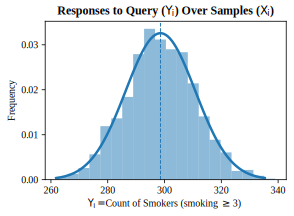

In [7]:
# Plot histogram of samples
Y = np.array(pac_lung_df.Y).flatten()
fig, ax = plt.subplots(figsize=(6.4*(2/3), 4.8*(2/3)))
plt.hist(Y, bins=20, density=True, alpha=0.5, color='tab:blue')

x = np.linspace(np.mean(Y) - 3*np.std(Y), np.mean(Y) + 3*np.std(Y), 100)
plt.plot(x, stats.norm.pdf(x, np.mean(Y), np.std(Y)), color='tab:blue', linewidth=2.5)
plt.axvline(np.mean(Y), color='tab:blue', linestyle='dashed', linewidth=1)

plt.title('Responses to Query ($Y_i$) Over Samples ($X_i$)')
plt.xlabel('$Y_i = $Count of Smokers (smoking $\geq$ 3) ')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figs/samples.png")

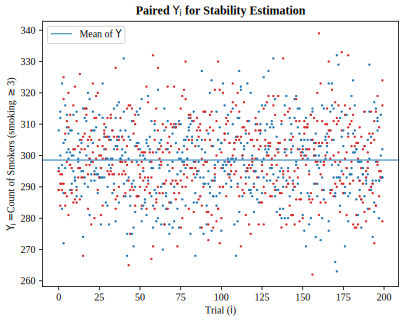

In [8]:
# plot sample points
tau = pac_lung_df.options.tau
dists = []
for i, (Y1, Y2) in enumerate(pac_lung_df.Y_pairs):
    mean = np.mean([*Y1, *Y2])
    dist = minimal_permutation_distance(Y1, Y2)
    _, y1, y2 = min([(abs(Y1[t] - Y2[t]), Y1[t], Y2[t]) for t in range(tau)], key=lambda x: x[0])
    plt.scatter([i]*len(Y1), Y1, alpha=1, color='tab:blue', s=2)
    plt.scatter([i]*len(Y2), Y2, alpha=1, color='tab:red', s=2)
    #plt.plot([i, i], [y1, y2], color='black', alpha=0.5, lw=1)
    dists.append(dist)

#plt.plot([], [], color='black', alpha=0.5, lw=1, label='Minimal Permutation Distance')

# depict mean as a line
plt.axhline(y=np.mean(Y), color='tab:blue', linestyle='-', lw=1, label='Mean of $Y$')
plt.title('Paired $Y_i$ for Stability Estimation')
plt.xlabel('Trial ($i$)')
plt.ylabel('$Y_i = $Count of Smokers (smoking $\geq$ 3)')
# min y axis must be 0
#plt.ylim(bottom=0)
plt.legend()
plt.savefig("figs/paired-samples.png")

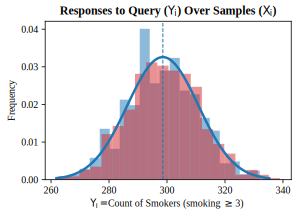

In [9]:
# Plot histogram of samples
fig, ax = plt.subplots(figsize=(6.4*(2/3), 4.8*(2/3)))
plt.hist(np.array([yp[0] for yp in pac_lung_df.Y_pairs]).flatten(), bins=20, density=True, alpha=0.5, color='tab:blue')
plt.hist(np.array([yp[1] for yp in pac_lung_df.Y_pairs]).flatten(), bins=20, density=True, alpha=0.5, color='tab:red')

x = np.linspace(np.mean(Y) - 3*np.std(Y), np.mean(Y) + 3*np.std(Y), 100)
plt.plot(x, stats.norm.pdf(x, np.mean(Y), np.std(Y)), color='tab:blue', linewidth=2.5)
plt.axvline(np.mean(Y), color='tab:blue', linestyle='dashed', linewidth=1)

plt.title('Responses to Query ($Y_i$) Over Samples ($X_i$)')
plt.xlabel('$Y_i = $Count of Smokers (smoking $\geq$ 3) ')
plt.ylabel('Frequency')
plt.tight_layout()

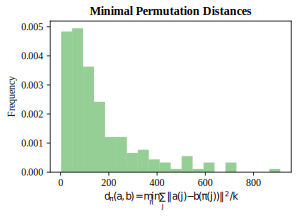

In [10]:
# plot distances of paired samples
fig, ax = plt.subplots(figsize=(6.4*(2/3), 4.8*(2/3)))
dists = [minimal_permutation_distance(Y1, Y2) for Y1, Y2 in pac_lung_df.Y_pairs]
plt.hist(dists, bins=20, density=True, alpha=0.5, color='tab:green')
#plt.plot(
#    np.linspace(np.mean(dists) - 3*np.std(dists), np.mean(dists) + 3*np.std(dists), 100),
#    stats.norm.pdf(np.linspace(np.mean(dists) - 3*np.std(dists), np.mean(dists) + 3*np.std(dists), 100), np.mean(dists), np.std(dists)), color='tab:green', linewidth=2.5)
plt.title('Minimal Permutation Distances')
plt.xlabel(r'$d_{\pi}(a, b) = \min_{\pi} \sum_{j} \left\|a(j) - b(\pi(j))\right\|^2 / k$')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figs/minimal-permutation-distance.png")

### Noise

Now we calculate the noise to add. I've attempted to construct what I need based on the PAC-ML code, but this probably has many errors.

Noise is estimated using Algorithm 2 from the PAC paper, with details taken from `rand_mechanism_noise` in the PAC-ML paper.

$\text{noise} = ((\psi + c) / (2*v))$ where $\psi$ is the average distance between paired samples and $v = \tt{max\_mi}/2$

In [11]:
# 3. Estimate Noise
pac_lung_df._estimate_noise()
pac_lung_df.noise_distribution

Measure Distances: 100%|██████████| 200/200 [00:00<00:00, 17698.98it/s]


GaussianDistribution(mean=0, variance=1276.5680000000007)

In [12]:
# 4. Noised Release
pac_lung_df._noised_release()

-1300.0687772335082

In [21]:
from pacdb.noise import noise_to_add
for mi in [1./64, 1./32, 1./16, 1./8, 1./4, 1./2, 1, 2, 4]:
    print(noise_to_add(pac_lung_df.avg_dist, pac_lung_df.options.c, mi))
for c in [10, 1, 0.1, 0.01, 0.001, 0.0001, 1/1e9]:
    print(noise_to_add(pac_lung_df.avg_dist, c, 1./4))

GaussianDistribution(mean=0, variance=10212.544000000005)
GaussianDistribution(mean=0, variance=5106.272000000003)
GaussianDistribution(mean=0, variance=2553.1360000000013)
GaussianDistribution(mean=0, variance=1276.5680000000007)
GaussianDistribution(mean=0, variance=638.2840000000003)
GaussianDistribution(mean=0, variance=319.14200000000017)
GaussianDistribution(mean=0, variance=159.57100000000008)
GaussianDistribution(mean=0, variance=79.78550000000004)
GaussianDistribution(mean=0, variance=39.89275000000002)
GaussianDistribution(mean=0, variance=678.2800000000003)
GaussianDistribution(mean=0, variance=642.2800000000003)
GaussianDistribution(mean=0, variance=638.6800000000003)
GaussianDistribution(mean=0, variance=638.3200000000003)
GaussianDistribution(mean=0, variance=638.2840000000003)
GaussianDistribution(mean=0, variance=638.2804000000003)
GaussianDistribution(mean=0, variance=638.2800000040003)


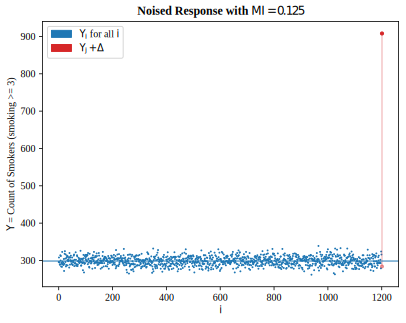

In [14]:
Yj = pac_lung_df._applyQuery(pac_lung_df.sampler.sample())

noise_to_add = pac_lung_df.noise_distribution.sample()
noised_Yj = Yj + noise_to_add
noised_Yj

# plot samples
plt.scatter(range(len(Y)), Y, alpha=1, color='tab:blue', s=1)
plt.axhline(y=np.mean(Y), color='tab:blue', linestyle='-', lw=1)

# plot noised response
plt.scatter([len(Y)+1], [Yj], alpha=0.4, color='tab:red', s=10)
plt.scatter([len(Y)+1], [noised_Yj], alpha=1, color='tab:red', s=10)
# plot arrow from sample to noised response
plt.arrow(len(Y)+1, Yj, 0, noised_Yj-Yj, color='tab:red', alpha=0.2, length_includes_head=True, head_width=3, head_length=3, lw=2)

plt.title(f'Noised Response with $MI = {pac_lung_df.options.max_mi}$')
plt.xlabel('$i$')
plt.ylabel('$Y$ = Count of Smokers (smoking >= 3)')
plt.legend(handles=[mpatches.Patch(color='tab:blue', label='$Y_i$ for all $i$'), mpatches.Patch(color='tab:red', label='$Y_j + \\Delta$')])
#plt.ylim(bottom=0)
plt.savefig("figs/original-vs-noised.png")

In [32]:
noised_Yj_samples = [pac_lung_df._noised_release(noise_to_add(pac_lung_df.avg_dist, 0.001, 4)) for _ in tqdm(range(100))]

100%|██████████| 100/100 [00:05<00:00, 17.96it/s]


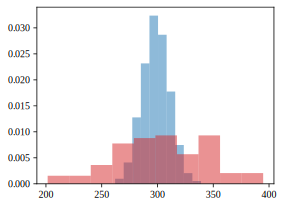

In [33]:
# Plot the distribution of noised release against the original
fig, ax = plt.subplots(figsize=(6.4*(2/3), 4.8*(2/3)))
plt.hist(np.array(pac_lung_df.Y).flatten(), bins=10, density=True, alpha=0.5, color='tab:blue')
plt.hist(noised_Yj_samples, bins=10, density=True, alpha=0.5, color='tab:red')
plt.show()

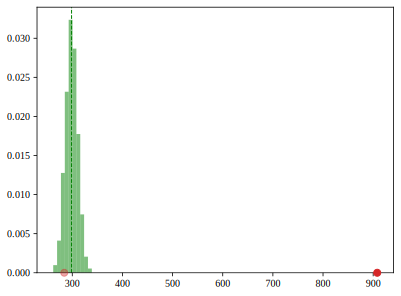

In [34]:
# plot noised response on original distribution
plt.hist(Y, bins=10, density=True, alpha=0.5, color='g')
plt.axvline(np.mean(Y), color='g', linestyle='dashed', linewidth=1)

plt.scatter([Yj], [0], alpha=0.4, color='tab:red', s=50, zorder=10, clip_on=False)
plt.scatter([noised_Yj], [0], alpha=1, color='tab:red', s=50, zorder=10, clip_on=False)

### Multiple Tables

In [ ]:
# Split the lung table into multiple tables over Patient Id
identity_df: DataFrame = lung_df.select("Name", "index", "Patient Id", "Age", "Gender")
identity_df.write.saveAsTable("identity", mode="overwrite")

symptoms_df: DataFrame = lung_df.select("Patient Id", "Chest Pain", "Coughing of Blood", "Fatigue", "Weight Loss", "Shortness of Breath", "Wheezing", "Swallowing Difficulty", "Clubbing of Finger Nails", "Frequent Cold", "Dry Cough", "Snoring")
symptoms_df.write.saveAsTable("symptoms", mode="overwrite")

risk_factors_df: DataFrame = lung_df.select("Patient Id", "Air Pollution", "Alcohol use", "Dust Allergy", "Occupational Hazards", "Genetic Risk", "Chronic Lung Disease", "Balanced Diet", "Obesity", "Smoking", "Passive Smoker")
risk_factors_df.write.saveAsTable("risk_factors", mode="overwrite")

In [ ]:
# Count the number of patients in each age group with chest pain who are smokers
spark.sql("""
        SELECT FLOOR(identity.Age / 10) * 10 AS Age_Group, COUNT(*) AS Count
        FROM identity
        JOIN symptoms ON identity.`Patient Id` = symptoms.`Patient Id`
        JOIN risk_factors ON identity.`Patient Id` = risk_factors.`Patient Id`
        WHERE risk_factors.Smoking >= 3
          AND symptoms.`Chest Pain` > 1
        GROUP BY FLOOR(identity.Age / 10) * 10
        ORDER BY Age_Group
        """).toPandas()

In [ ]:
# spark_df: DataFrame = (identity_df.join(symptoms_df, "Patient Id") # First do all the joins
#                  .join(risk_factors_df, "Patient Id"))
# spark_df.count()

In [ ]:
# 0. Do all joins, etc. to get the data you want into a single Spark DataFrame. Turn it into a PACDataFrame.
spark_df: DataFrame = (identity_df.join(symptoms_df.filter(symptoms_df["Chest Pain"] > 1), "Patient Id") # First do all the joins
                 .join(risk_factors_df.filter(risk_factors_df["Smoking"] >= 3) , "Patient Id") # N
        )
pac_lung_df: PACDataFrame = PACDataFrame(lung_df)
               
# Define your query as a function that takes a DataFrame and returns (for now) an integer
def A(x: DataFrame) -> int:
    """Function to make private"""
    y = (x
        .withColumn("Age_Group", (x["Age"] / 10).cast("int") * 10)
        .groupBy("Age_Group")
        .count()
        .orderBy("Age_Group"))
    return y

# Attach the predicate function to the PACDataFrame
pac_lung_df = pac_lung_df.withQuery(A)

In [ ]:
# 1. Sampling
# Set sampler options on the PACDataFrame
pac_lung_df = pac_lung_df.withSamplerOptions(
                    SamplerOptions(
                        withReplacement=False, 
                        fraction=0.5
                    )
                )

trials = 200
X: List[DataFrame] = [pac_lung_df.sample() for _ in range(trials * 2)]

In [ ]:
X[1].show()

In [ ]:
# 2. Measure Stability

# Eventually this should become something like PACDataFrame.analyze()
# The challenge is how to handle the way that sampling affects the outcome of the predicate
# for all predicate types: i.e. we need to multiply to cancel out sampling rate for count and sum

Y: list[int] = []

for Xi in X:
    Yi = pac_lung_df._applyPredicate(Xi)
    Y.append(Yi)  # store result of query

Y_pairs = list(zip(Y[::2], Y[1::2]))

In [ ]:
Y[1].toPandas()

In [ ]:
# 3. Estimate Noise
c = 0.001
max_mi = 1/8  # 2 * v

import pandas as pd

# find paired distances between dataframes: take count column as vector
avg_dist = 0
tau = len(np.array(Y_pairs[0][0].toPandas()["count"]))
for trial in range(trials):
    y1, y2 = Y_pairs[trial][0], Y_pairs[trial][1]
    # get the count column as an array of ints
    y1: np.array = np.array(y1.toPandas()["count"])
    y2: np.array = np.array(y2.toPandas()["count"])
    # compute the distance between the two vectors
    dist = 0.

    for ind in range(tau):
        dist += np.linalg.norm(np.array(y1[ind]) - np.array(y2[ind]))**2 / tau
    avg_dist += dist
    #ys.append((y1, y2))

avg_dist /= trials

In [ ]:
avg_dist

In [ ]:
import paclib
# At different levels of MI, compute noise to add
noise_params = []
for max_mi in [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]:
    print(f"avg_dist: {avg_dist}, c: {c}, max_mi: {max_mi:8} => {paclib.noise_to_add(avg_dist, c, max_mi)}")
    noise_params.append([
        max_mi, 
        paclib.noise_to_add(avg_dist, c, max_mi).mean, 
        paclib.noise_to_add(avg_dist, c, max_mi).variance
        ])

In [ ]:
# 4. Noised Release

# obtain one more sample to use for noised release
Yj = pac_lung_df._applyPredicate(pac_lung_df.sample())
Yj_arr: np.array = np.array(Yj.toPandas()["count"])
print(Yj_arr)

c = 0.001
mi = 1/16

noise_to_add = paclib.noise_to_add(avg_dist, c, mi).sample()
print(noise_to_add)

noised_Yj = Yj_arr + noise_to_add
noised_Yj